In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-expression-recognition-dataset


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

In [ ]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # Get the number of epochs
    epochs = len(model_history.history['accuracy'])
    epoch_range = range(1, epochs + 1)

    # Plot accuracy
    axs[0].plot(epoch_range, model_history.history['accuracy'])
    axs[0].plot(epoch_range, model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid(True)

    # Plot loss
    axs[1].plot(epoch_range, model_history.history['loss'])
    axs[1].plot(epoch_range, model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid(True)

    plt.tight_layout()
    fig.savefig('plot.png')
    plt.show()

def check_dataset_structure():
    """
    Check the structure of your dataset to verify paths and count images
    """
    base_path = '/kaggle/input/face-expression-recognition-dataset'

    print("Dataset structure:")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")


In [ ]:
# Check dataset structure first
check_dataset_structure()

# Updated paths for the correct dataset location
base_dataset_path = '/kaggle/input/face-expression-recognition-dataset'

# Common possible paths for this specific dataset:
possible_paths = [
    f'{base_dataset_path}/images/train',
    f'{base_dataset_path}/images/validation',
    f'{base_dataset_path}/train',
    f'{base_dataset_path}/test',
    f'{base_dataset_path}/Training',
    f'{base_dataset_path}/Testing',
    f'{base_dataset_path}/validation',
    f'{base_dataset_path}/val',
    base_dataset_path
]

print("\nChecking possible train/validation paths:")
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
        if os.path.isdir(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if subdirs:
                print(f"  Subdirectories: {subdirs}")
    else:
        print(f"✗ Not found: {path}")

# Also check for CSV files (some datasets come as CSV)
print("\nLooking for CSV files:")
for root, dirs, files in os.walk(base_dataset_path):
    for file in files:
        if file.endswith('.csv'):
            print(f"Found CSV: {os.path.join(root, file)}")

# Set the correct paths based on common patterns
# Update these after running the structure check
train_dir = f'{base_dataset_path}/images/train'
val_dir = f'{base_dataset_path}/images/validation'

# Alternative paths to try if the above don't work:
# train_dir = f'{base_dataset_path}/train'
# val_dir = f'{base_dataset_path}/test'

Dataset structure:
face-expression-recognition-dataset/
  images/
    validation/
      surprise/
        13288.jpg
        24201.jpg
        26556.jpg
        26076.jpg
        27577.jpg
        ... and 792 more files
      fear/
        31973.jpg
        7894.jpg
        32279.jpg
        1075.jpg
        13899.jpg
        ... and 1013 more files
      angry/
        24819.jpg
        30325.jpg
        30273.jpg
        764.jpg
        15979.jpg
        ... and 955 more files
      neutral/
        34530.jpg
        16257.jpg
        8352.jpg
        30371.jpg
        27650.jpg
        ... and 1211 more files
      sad/
        23407.jpg
        29970.jpg
        19674.jpg
        29112.jpg
        8953.jpg
        ... and 1134 more files
      disgust/
        11529.jpg
        25267.jpg
        8948.jpg
        19770.jpg
        7405.jpg
        ... and 106 more files
      happy/
        7737.jpg
        3138.jpg
        5705.jpg
        4640.jpg
        22604.jpg
        ... and 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Training parameters
batch_size = 64
num_epoch = 50 # increased for better convergence

# Data augmentation for better training performance
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))


validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

# Model with BatchNormalization
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

print("✅ Model architecture created successfully!")
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
# history = model.fit(
#     train_generator,
#     epochs=num_epoch,
#     validation_data=validation_generator,
#     callbacks=[early_stop, lr_scheduler]
# )
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epoch,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model architecture created successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 9,684,999 (36.95 MB)

 Trainable params: 9,683,271 (36.94 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.1631 - loss: 2.3534 - val_accuracy: 0.0628 - val_loss: 1.9759 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.1566 - loss: 2.0631 - val_accuracy: 0.2072 - val_loss: 1.9067 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.1826 - loss: 1.9768 - val_accuracy: 0.1646 - val_loss: 2.0117 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.2043 - loss: 1.8788 - val_accuracy: 0.2484 - val_loss: 1.8610 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.2178 - loss: 1.8608 - val_accuracy: 0.2129 - val_loss: 1.8984 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.2344 - loss: 1.8302 - val_accuracy: 0.3469 - val_loss: 1.7031 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.2737 - loss:

In [ ]:
# Training parameters
batch_size = 64
num_epoch = 50

# Data augmentation for better training performance
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

labels = train_generator.classes

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


print("Model architecture created successfully!")
model.summary()

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Mostly did not work, but can be tried.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compute class weights (optional but helps with imbalanced classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epoch,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)

In [ ]:
#too big network for this data
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Convert grayscale to 3 channels because ResNet expects 3 channels
def preprocess_input_grayscale(x):
    return tf.image.grayscale_to_rgb(x)

# Updated data generators (now with 3 channels)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input_grayscale
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input_grayscale
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",  # We still load grayscale, then convert in preprocessing
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'
)

# Create ResNet50 base
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(48, 48, 3))  # 3-channel due to preprocessing
)

# Optionally freeze early layers
for layer in resnet_base.layers[:100]:
    layer.trainable = False

# Add custom classification head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Final model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_205"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 19,979,271 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Found 7066 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7066/7066 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step


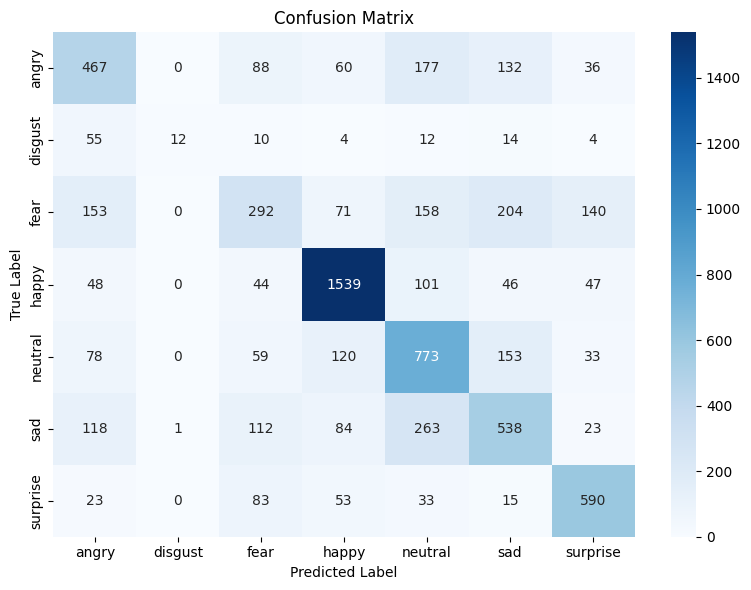

              precision    recall  f1-score   support

       angry       0.50      0.49      0.49       960
     disgust       0.92      0.11      0.19       111
        fear       0.42      0.29      0.34      1018
       happy       0.80      0.84      0.82      1825
     neutral       0.51      0.64      0.57      1216
         sad       0.49      0.47      0.48      1139
    surprise       0.68      0.74      0.71       797

    accuracy                           0.60      7066
   macro avg       0.62      0.51      0.51      7066
weighted avg       0.59      0.60      0.59      7066



In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the trained model
model = load_model('model50.keras')

# 2. Recreate the validation generator (with shuffle=False!)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=1,  # Use batch_size=1 to align predictions exactly
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

# 3. Predict on validation set
predictions = model.predict(val_generator, steps=val_generator.samples)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# 4. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

# 5. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 6. (Optional) Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
